# Comparative Analysis of Text Classification with Multiple Embeddings

**Course:** Text Classification Assignment  
**Team:** Group 6  
**Members:** Erneste, Charlotte, Orpheus, David  
**Dataset:** SMS Spam Collection  
**Date:** February 2026

---

## Team Responsibilities

| Member | Model | Embeddings |
|--------|-------|------------|
| **Erneste** | Logistic Regression | TF-IDF, Skip-gram, GloVe |
| **Charlotte** | RNN | TF-IDF, Skip-gram, GloVe |
| **Orpheus** | LSTM | TF-IDF, Skip-gram, GloVe |
| **David** | GRU | TF-IDF, Skip-gram, GloVe |

---

## 1. Problem Definition & Dataset Justification

### 1.1 Problem Statement

Spam detection is a critical text classification task in communication systems. This project aims to:
- Compare performance of different model architectures (traditional ML vs. sequence models)
- Evaluate the impact of various word embedding techniques on classification accuracy
- Identify optimal embedding-model combinations for spam detection

### 1.2 Dataset Justification

**SMS Spam Collection Dataset** (UCI ML Repository)
- **Size:** 5,574 SMS messages
- **Classes:** Binary (spam/ham)
- **Domain Relevance:** Real-world application in mobile security
- **Research Value:** Benchmark dataset for comparative analysis

---

## 2. Setup and Data Loading

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Install required packages and download NLTK resources
import subprocess
import sys

print("Installing required packages...")
packages = ['gensim', 'nltk', 'scikit-learn', 'pandas', 'numpy', 'matplotlib', 'seaborn']

for package in packages:
    try:
        __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        print(f"✓ {package} installed successfully")

# Download NLTK resources
print("\nDownloading NLTK resources...")
import nltk
nltk_resources = ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'omw-1.4', 'averaged_perceptron_tagger']
for resource in nltk_resources:
    try:
        nltk.download(resource, quiet=True)
        print(f"✓ {resource} downloaded")
    except Exception as e:
        print(f"⚠ {resource} download skipped (may not be critical)")

print("\nAll packages and NLTK resources are ready!")

Installing required packages...
✓ gensim already installed
✓ nltk already installed
Installing scikit-learn...
✓ scikit-learn installed successfully
✓ pandas already installed
✓ numpy already installed
✓ matplotlib already installed
✓ seaborn already installed

✓ punkt downloaded
✓ punkt_tab downloaded
✓ stopwords downloaded
✓ wordnet downloaded
✓ omw-1.4 downloaded
✓ averaged_perceptron_tagger downloaded

All packages and NLTK resources are ready!


In [15]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Text processing libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Word embeddings
from gensim.models import Word2Vec
import gensim.downloader as api

# For time tracking
import time
from datetime import datetime

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.19.0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
# Load the dataset
dataset = pd.read_csv('/content/drive/MyDrive/Spam_Classification/spam.csv', encoding='latin-1')

# Display basic information
print("Dataset loaded successfully!")
print(f"\nDataset shape: {dataset.shape}")
print(f"\nFirst few rows:")
dataset.head()

Dataset loaded successfully!

Dataset shape: (5572, 5)

First few rows:


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## 3. Exploratory Data Analysis (EDA)

**Collaborative Section - All Team Members**

This section provides comprehensive analysis of the SMS Spam dataset to understand its characteristics and inform preprocessing decisions.

In [16]:
# Data cleaning and preparation
# The dataset has extra columns, keep only the relevant ones
df = dataset[['v1', 'v2']].copy()
df.columns = ['label', 'message']

# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print(f"\nTotal samples: {len(df)}")

# Display dataset info
df.info()

Missing values:
label      0
message    0
dtype: int64

Total samples: 5572
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### 3.1 Class Distribution Analysis

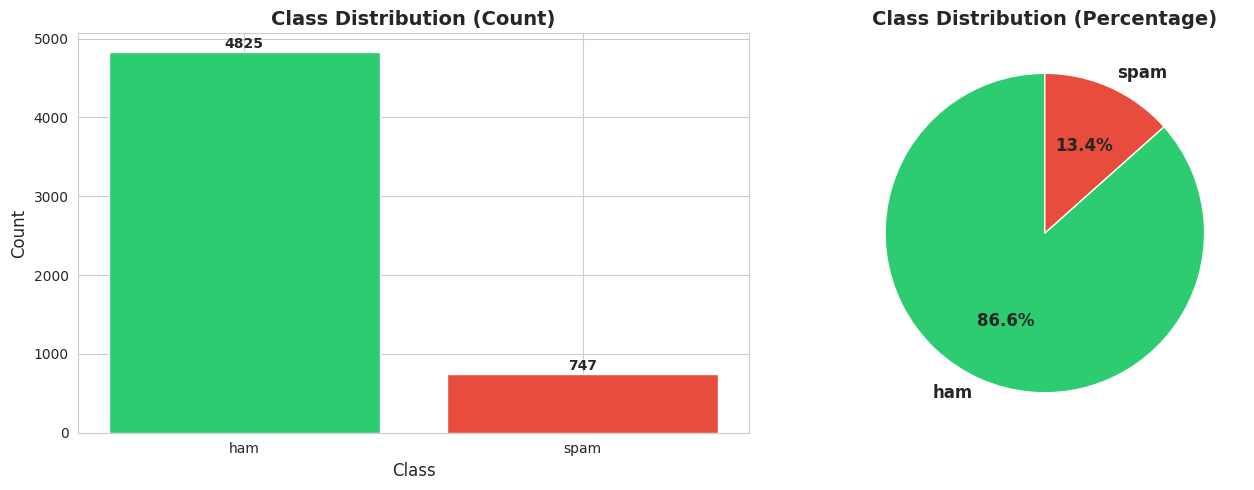


Class Distribution Statistics:
label
ham     4825
spam     747
Name: count, dtype: int64

Class Balance Ratio (Ham:Spam): 6.46:1
Dataset is imbalanced


In [17]:
# Visualization 1: Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
class_counts = df['label'].value_counts()
axes[0].bar(class_counts.index, class_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("\nClass Distribution Statistics:")
print(class_counts)
print(f"\nClass Balance Ratio (Ham:Spam): {class_counts['ham']/class_counts['spam']:.2f}:1")
print(f"Dataset is {'imbalanced' if class_counts['ham']/class_counts['spam'] > 2 else 'balanced'}")

### 3.2 Text Length Analysis

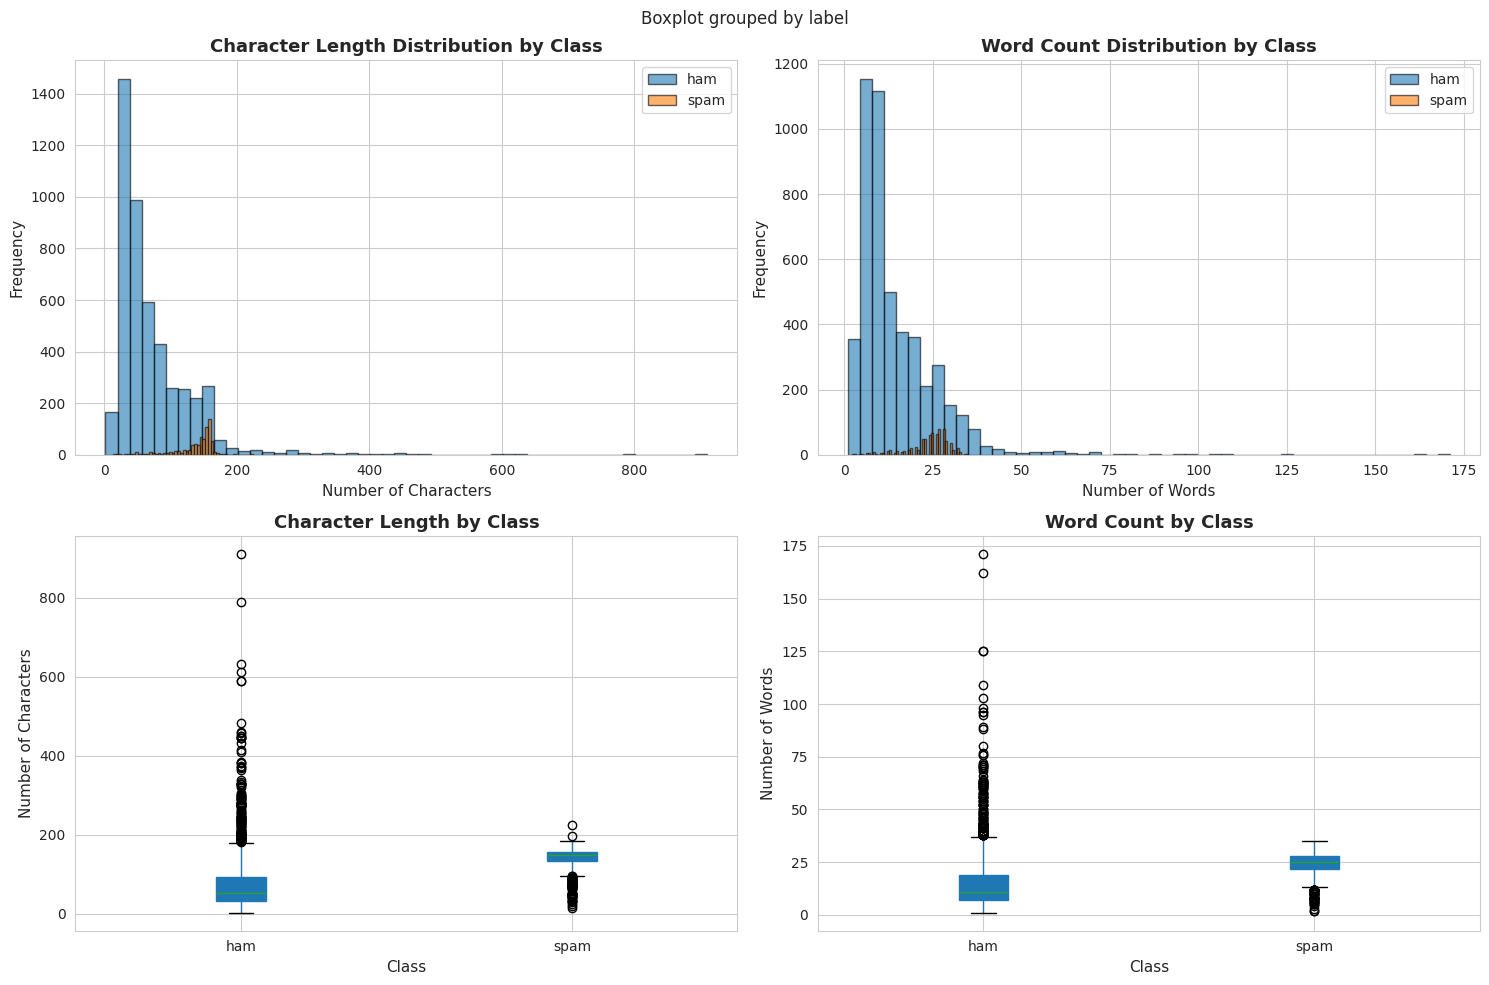


Text Length Statistics by Class:

HAM Messages:
       message_length   word_count
count     4825.000000  4825.000000
mean        71.023627    14.200622
std         58.016023    11.424511
min          2.000000     1.000000
25%         33.000000     7.000000
50%         52.000000    11.000000
75%         92.000000    19.000000
max        910.000000   171.000000

SPAM Messages:
       message_length  word_count
count      747.000000  747.000000
mean       138.866131   23.851406
std         29.183082    5.811898
min         13.000000    2.000000
25%        132.500000   22.000000
50%        149.000000   25.000000
75%        157.000000   28.000000
max        224.000000   35.000000


In [18]:
# Calculate text statistics
df['message_length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

# Visualization 2: Text Length Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length distribution by class
for label in ['ham', 'spam']:
    data = df[df['label'] == label]['message_length']
    axes[0, 0].hist(data, bins=50, alpha=0.6, label=label, edgecolor='black')
axes[0, 0].set_title('Character Length Distribution by Class', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Number of Characters', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].legend()

# Word count distribution by class
for label in ['ham', 'spam']:
    data = df[df['label'] == label]['word_count']
    axes[0, 1].hist(data, bins=50, alpha=0.6, label=label, edgecolor='black')
axes[0, 1].set_title('Word Count Distribution by Class', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Number of Words', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].legend()

# Box plot - Character length
df.boxplot(column='message_length', by='label', ax=axes[1, 0], patch_artist=True)
axes[1, 0].set_title('Character Length by Class', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Class', fontsize=11)
axes[1, 0].set_ylabel('Number of Characters', fontsize=11)
plt.sca(axes[1, 0])
plt.xticks([1, 2], ['ham', 'spam'])

# Box plot - Word count
df.boxplot(column='word_count', by='label', ax=axes[1, 1], patch_artist=True)
axes[1, 1].set_title('Word Count by Class', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Class', fontsize=11)
axes[1, 1].set_ylabel('Number of Words', fontsize=11)
plt.sca(axes[1, 1])
plt.xticks([1, 2], ['ham', 'spam'])

plt.tight_layout()
plt.show()

# Print statistics
print("\nText Length Statistics by Class:")
print("\nHAM Messages:")
print(df[df['label'] == 'ham'][['message_length', 'word_count']].describe())
print("\nSPAM Messages:")
print(df[df['label'] == 'spam'][['message_length', 'word_count']].describe())

### 3.3 Vocabulary Analysis

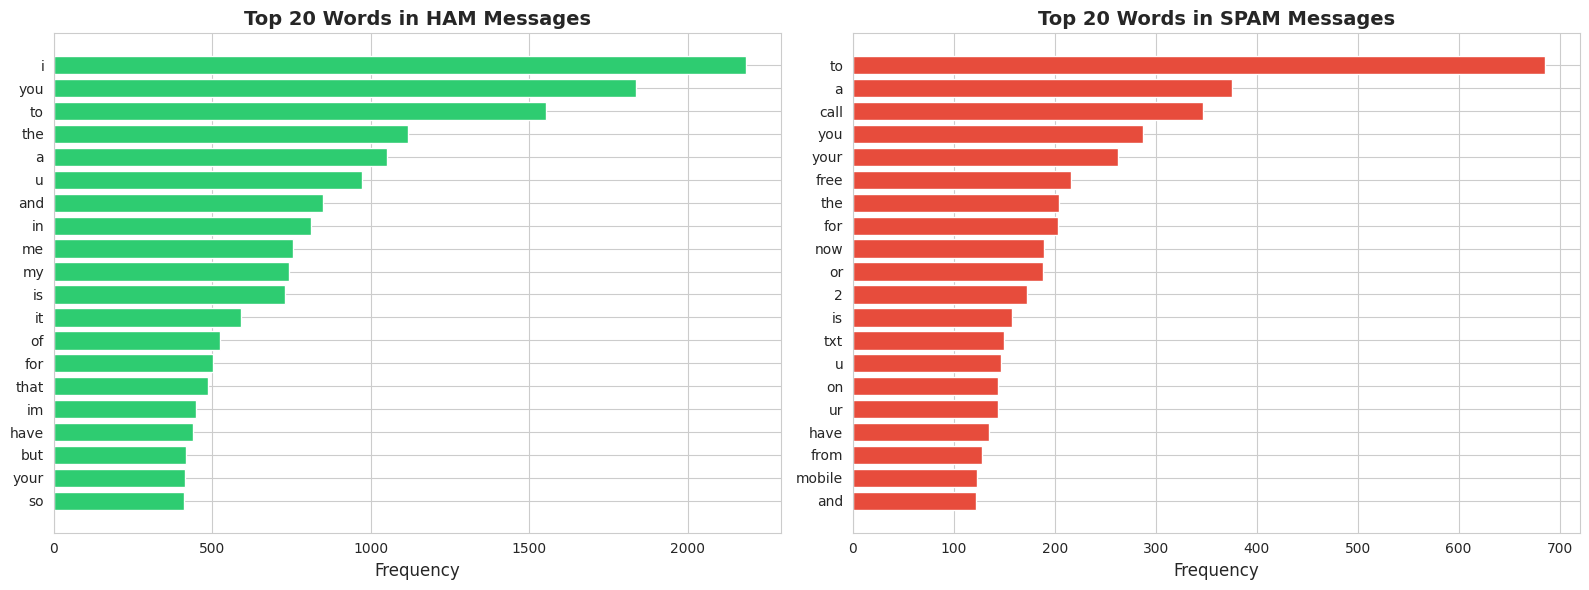


Vocabulary Statistics:
Unique words in HAM: 10882
Unique words in SPAM: 3732
Total unique words: 13496


In [19]:
# Visualization 3: Vocabulary Analysis
from collections import Counter
import string

def get_word_frequency(messages, top_n=20):
    """Extract top N most common words from messages"""
    all_words = []
    for msg in messages:
        # Simple tokenization and lowercasing
        words = msg.lower().translate(str.maketrans('', '', string.punctuation)).split()
        all_words.extend(words)
    return Counter(all_words).most_common(top_n)

# Get word frequencies for each class
ham_words = get_word_frequency(df[df['label'] == 'ham']['message'])
spam_words = get_word_frequency(df[df['label'] == 'spam']['message'])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# HAM words
words_ham, counts_ham = zip(*ham_words)
axes[0].barh(range(len(words_ham)), counts_ham, color='#2ecc71')
axes[0].set_yticks(range(len(words_ham)))
axes[0].set_yticklabels(words_ham)
axes[0].invert_yaxis()
axes[0].set_title('Top 20 Words in HAM Messages', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency', fontsize=12)

# SPAM words
words_spam, counts_spam = zip(*spam_words)
axes[1].barh(range(len(words_spam)), counts_spam, color='#e74c3c')
axes[1].set_yticks(range(len(words_spam)))
axes[1].set_yticklabels(words_spam)
axes[1].invert_yaxis()
axes[1].set_title('Top 20 Words in SPAM Messages', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# Calculate vocabulary size
all_words_ham = ' '.join(df[df['label'] == 'ham']['message']).lower().split()
all_words_spam = ' '.join(df[df['label'] == 'spam']['message']).lower().split()
all_words_total = ' '.join(df['message']).lower().split()

print("\nVocabulary Statistics:")
print(f"Unique words in HAM: {len(set(all_words_ham))}")
print(f"Unique words in SPAM: {len(set(all_words_spam))}")
print(f"Total unique words: {len(set(all_words_total))}")

### 3.4 Sample Messages Analysis

SAMPLE HAM MESSAGES

1. Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

2. Ok lar... Joking wif u oni...

3. U dun say so early hor... U c already then say...

4. Nah I don't think he goes to usf, he lives around here though

5. Even my brother is not like to speak with me. They treat me like aids patent.

SAMPLE SPAM MESSAGES

1. Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

2. FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv

3. WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.

4. Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile U

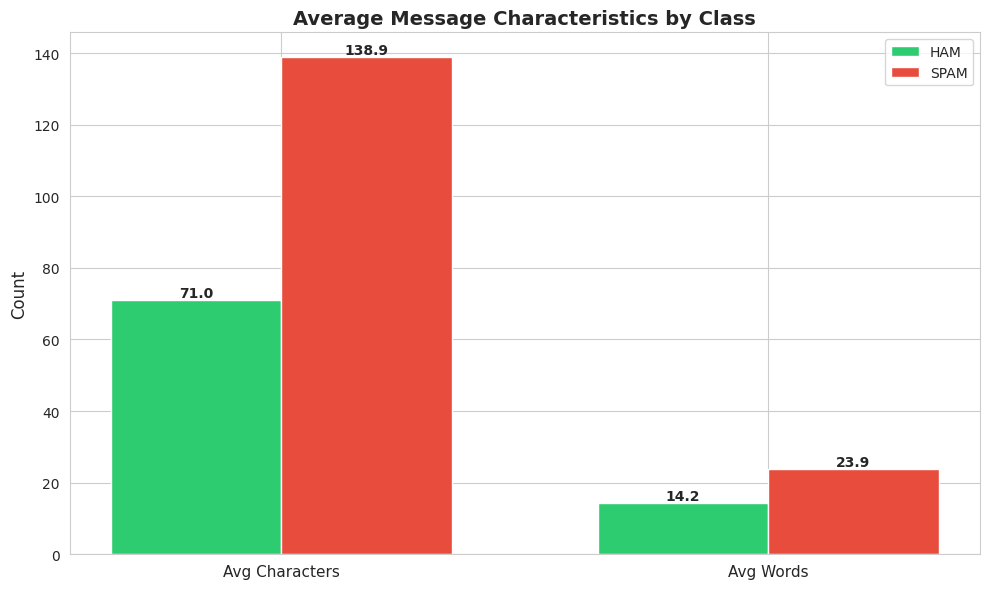

In [20]:
# Visualization 4: Sample messages from each class
print("="*80)
print("SAMPLE HAM MESSAGES")
print("="*80)
for i, msg in enumerate(df[df['label'] == 'ham']['message'].head(5), 1):
    print(f"\n{i}. {msg}")

print("\n" + "="*80)
print("SAMPLE SPAM MESSAGES")
print("="*80)
for i, msg in enumerate(df[df['label'] == 'spam']['message'].head(5), 1):
    print(f"\n{i}. {msg}")

# Additional visualization: Average metrics comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

metrics = ['Avg Characters', 'Avg Words']
ham_metrics = [
    df[df['label'] == 'ham']['message_length'].mean(),
    df[df['label'] == 'ham']['word_count'].mean()
]
spam_metrics = [
    df[df['label'] == 'spam']['message_length'].mean(),
    df[df['label'] == 'spam']['word_count'].mean()
]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, ham_metrics, width, label='HAM', color='#2ecc71')
bars2 = ax.bar(x + width/2, spam_metrics, width, label='SPAM', color='#e74c3c')

ax.set_ylabel('Count', fontsize=12)
ax.set_title('Average Message Characteristics by Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 3.5 EDA Summary and Insights

**Key Findings:**

1. **Class Imbalance:** The dataset shows significant class imbalance favoring HAM messages
2. **Text Length:** SPAM messages tend to be longer on average than HAM messages
3. **Vocabulary Patterns:** Distinct word patterns exist between classes (e.g., promotional words in SPAM)
4. **Preprocessing Needs:**
   - Stopword removal required
   - Case normalization needed
   - Special character handling important

**Implications for Modeling:**
- Consider class weighting or resampling for imbalance
- Text length features may be informative
- Rich vocabulary suggests embeddings will capture meaningful patterns

---

## 4. Data Preprocessing Pipeline

**Collaborative Section - Shared Preprocessing Strategy**

In [21]:
# Encode labels
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})

print("Label encoding completed:")
print(df[['label', 'label_encoded']].value_counts())

Label encoding completed:
label  label_encoded
ham    0                4825
spam   1                 747
Name: count, dtype: int64


In [22]:
# Shared text preprocessing function
def preprocess_text(text, remove_stopwords=True):
    """
    Comprehensive text preprocessing pipeline

    Steps:
    1. Lowercase conversion
    2. Remove URLs and email addresses
    3. Remove special characters and digits
    4. Tokenization
    5. Stopword removal (optional)
    6. Lemmatization

    Args:
        text (str): Input text
        remove_stopwords (bool): Whether to remove stopwords

    Returns:
        str: Preprocessed text
    """
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Remove empty tokens and join
    tokens = [word for word in tokens if len(word) > 1]

    return ' '.join(tokens)

# Test preprocessing
sample_text = df['message'].iloc[0]
print("Original text:")
print(sample_text)
print("\nPreprocessed text (with stopword removal):")
print(preprocess_text(sample_text, remove_stopwords=True))
print("\nPreprocessed text (without stopword removal):")
print(preprocess_text(sample_text, remove_stopwords=False))

Original text:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Preprocessed text (with stopword removal):
go jurong point crazy available bugis great world la buffet cine got amore wat

Preprocessed text (without stopword removal):
go until jurong point crazy available only in bugis great world la buffet cine there got amore wat


In [23]:
# Apply preprocessing to entire dataset
print("Preprocessing entire dataset...")
start_time = time.time()

# Create two versions: with and without stopwords
# For TF-IDF: typically better WITH stopword removal
df['processed_text_stopwords'] = df['message'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

# For Word2Vec/GloVe: typically better WITHOUT stopword removal (context matters)
df['processed_text_no_stopwords'] = df['message'].apply(lambda x: preprocess_text(x, remove_stopwords=False))

end_time = time.time()
print(f"Preprocessing completed in {end_time - start_time:.2f} seconds")

# Display examples
print("\nPreprocessing Examples:")
print("="*80)
for i in range(3):
    print(f"\nOriginal: {df['message'].iloc[i]}")
    print(f"With stopword removal: {df['processed_text_stopwords'].iloc[i]}")
    print(f"Without stopword removal: {df['processed_text_no_stopwords'].iloc[i]}")
    print("-"*80)

Preprocessing entire dataset...
Preprocessing completed in 1.92 seconds

Preprocessing Examples:

Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
With stopword removal: go jurong point crazy available bugis great world la buffet cine got amore wat
Without stopword removal: go until jurong point crazy available only in bugis great world la buffet cine there got amore wat
--------------------------------------------------------------------------------

Original: Ok lar... Joking wif u oni...
With stopword removal: ok lar joking wif oni
Without stopword removal: ok lar joking wif oni
--------------------------------------------------------------------------------

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
With stopword removal: free entry wkly comp win fa cup final tkts st may text fa receive e

In [24]:
# Train-Test Split
# Using stratified split to maintain class balance
X = df['message']  # Original text for reference
y = df['label_encoded']

# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Get corresponding preprocessed versions
train_indices = X_train.index
test_indices = X_test.index

# For TF-IDF (with stopword removal)
X_train_tfidf = df.loc[train_indices, 'processed_text_stopwords']
X_test_tfidf = df.loc[test_indices, 'processed_text_stopwords']

# For Word2Vec/GloVe (without stopword removal)
X_train_w2v = df.loc[train_indices, 'processed_text_no_stopwords']
X_test_w2v = df.loc[test_indices, 'processed_text_no_stopwords']

print("Train-Test Split Summary:")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in test set:")
print(y_test.value_counts())

Train-Test Split Summary:
Training samples: 4457 (80.0%)
Test samples: 1115 (20.0%)

Class distribution in training set:
label_encoded
0    3859
1     598
Name: count, dtype: int64

Class distribution in test set:
label_encoded
0    966
1    149
Name: count, dtype: int64


---

## 5. Word Embedding Implementations

**Collaborative Section - Embedding Preparation for All Models**

### 5.1 TF-IDF Vectorization

**Theory:** TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure that evaluates word importance in a document relative to a corpus.

**Advantages:**
- Simple and efficient
- Works well with traditional ML models
- Captures term importance

**Configuration:**
- Max features: 5000
- N-gram range: (1, 2) - unigrams and bigrams
- Min document frequency: 2

In [25]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)

# Fit on training data and transform both train and test
X_train_tfidf_vectors = tfidf_vectorizer.fit_transform(X_train_tfidf)
X_test_tfidf_vectors = tfidf_vectorizer.transform(X_test_tfidf)

print("TF-IDF Vectorization Complete:")
print(f"Training set shape: {X_train_tfidf_vectors.shape}")
print(f"Test set shape: {X_test_tfidf_vectors.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"\nTop 20 TF-IDF features:")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:20])

TF-IDF Vectorization Complete:
Training set shape: (4457, 5000)
Test set shape: (1115, 5000)
Vocabulary size: 5000

Top 20 TF-IDF features:
['aathilove' 'aathilove lot' 'abi' 'abiola' 'able' 'able deliver'
 'able get' 'able pay' 'abt' 'abt already' 'abt tht' 'abta'
 'abta complimentary' 'aburo' 'aburo enjoy' 'ac' 'acc' 'accept'
 'accept brother' 'accept dayu']


### 5.2 Word2Vec Embeddings (Skip-gram)

**Theory:** Skip-gram predicts context words from a target word, learning distributed representations.

**Advantages:**
- Captures semantic relationships
- Works well with smaller datasets
- Preserves word context

**Configuration:**
- Vector size: 100
- Window: 5
- Min count: 2
- Training algorithm: Skip-gram (sg=1)

In [26]:
# Prepare tokenized sentences for Word2Vec
train_sentences = [text.split() for text in X_train_w2v]
test_sentences = [text.split() for text in X_test_w2v]

# Train Skip-gram model
print("Training Skip-gram Word2Vec model...")
skipgram_model = Word2Vec(
    sentences=train_sentences,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,  # Skip-gram
    workers=4,
    epochs=10,
    seed=42
)

print(f"Skip-gram model trained successfully!")
print(f"Vocabulary size: {len(skipgram_model.wv)}")
print(f"Vector dimensions: {skipgram_model.wv.vector_size}")

# Test word similarity
print("\nWord similarity examples (Skip-gram):")
test_words = ['free', 'call', 'win']
for word in test_words:
    if word in skipgram_model.wv:
        similar = skipgram_model.wv.most_similar(word, topn=3)
        print(f"Words similar to '{word}': {[w[0] for w in similar]}")

Training Skip-gram Word2Vec model...
Skip-gram model trained successfully!
Vocabulary size: 3211
Vector dimensions: 100

Word similarity examples (Skip-gram):
Words similar to 'free': ['colour', 'update', 'camcorder']
Words similar to 'call': ['match', 'hr', 'quoting']
Words similar to 'win': ['chance', 'wkly', 'entry']


In [27]:
# Function to convert text to average Word2Vec vector
def text_to_w2v_vector(text, model, vector_size=100):
    """
    Convert text to averaged Word2Vec vector
    """
    words = text.split()
    word_vectors = []

    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])

    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Convert training and test data to Skip-gram vectors
print("Converting text to Skip-gram vectors...")
X_train_skipgram = np.array([text_to_w2v_vector(text, skipgram_model) for text in X_train_w2v])
X_test_skipgram = np.array([text_to_w2v_vector(text, skipgram_model) for text in X_test_w2v])

print(f"Skip-gram training vectors shape: {X_train_skipgram.shape}")
print(f"Skip-gram test vectors shape: {X_test_skipgram.shape}")

Converting text to Skip-gram vectors...
Skip-gram training vectors shape: (4457, 100)
Skip-gram test vectors shape: (1115, 100)


### 5.3 GloVe Pre-trained Embeddings

**Theory:** GloVe (Global Vectors) learns embeddings from global word co-occurrence statistics.

**Advantages:**
- Pre-trained on large corpora
- Captures both local and global context
- Better performance on semantic tasks

**Configuration:**
- Using glove-wiki-gigaword-100 (100-dimensional vectors)
- Trained on Wikipedia + Gigaword corpus

In [28]:
# Load pre-trained GloVe embeddings
print("Loading pre-trained GloVe embeddings...")
print("This may take a few minutes on first download...")

try:
    glove_model = api.load('glove-wiki-gigaword-100')
    print(f"GloVe embeddings loaded successfully!")
    print(f"Vocabulary size: {len(glove_model)}")
    print(f"Vector dimensions: {glove_model.vector_size}")

    # Test word similarity
    print("\nWord similarity examples (GloVe):")
    for word in test_words:
        if word in glove_model:
            similar = glove_model.most_similar(word, topn=3)
            print(f"Words similar to '{word}': {[w[0] for w in similar]}")
except Exception as e:
    print(f"Error loading GloVe: {e}")
    print("Continuing without GloVe embeddings...")

Loading pre-trained GloVe embeddings...
This may take a few minutes on first download...
[==================================================] 100.0% 128.1/128.1MB downloaded
GloVe embeddings loaded successfully!
Vocabulary size: 400000
Vector dimensions: 100

Word similarity examples (GloVe):
Words similar to 'free': ['through', 'without', 'allowed']
Words similar to 'call': ['calls', 'calling', 'ask']
Words similar to 'win': ['victory', 'winning', 'won']


In [29]:
# Convert text to GloVe vectors
def text_to_glove_vector(text, model, vector_size=100):
    """
    Convert text to averaged GloVe vector
    """
    words = text.split()
    word_vectors = []

    for word in words:
        if word in model:
            word_vectors.append(model[word])

    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Convert training and test data to GloVe vectors
print("Converting text to GloVe vectors...")
X_train_glove = np.array([text_to_glove_vector(text, glove_model) for text in X_train_w2v])
X_test_glove = np.array([text_to_glove_vector(text, glove_model) for text in X_test_w2v])

print(f"GloVe training vectors shape: {X_train_glove.shape}")
print(f"GloVe test vectors shape: {X_test_glove.shape}")

Converting text to GloVe vectors...
GloVe training vectors shape: (4457, 100)
GloVe test vectors shape: (1115, 100)


### 5.4 Embedding Summary

In [30]:
# Summary of all embeddings
embedding_summary = pd.DataFrame({
    'Embedding Type': ['TF-IDF', 'Skip-gram (Word2Vec)', 'GloVe'],
    'Train Shape': [X_train_tfidf_vectors.shape, X_train_skipgram.shape, X_train_glove.shape],
    'Test Shape': [X_test_tfidf_vectors.shape, X_test_skipgram.shape, X_test_glove.shape],
    'Dimensions': [X_train_tfidf_vectors.shape[1], 100, 100],
    'Type': ['Sparse', 'Dense', 'Dense']
})

print("\n" + "="*80)
print("EMBEDDING SUMMARY")
print("="*80)
print(embedding_summary.to_string(index=False))
print("\nAll embeddings prepared successfully!")


EMBEDDING SUMMARY
      Embedding Type  Train Shape   Test Shape  Dimensions   Type
              TF-IDF (4457, 5000) (1115, 5000)        5000 Sparse
Skip-gram (Word2Vec)  (4457, 100)  (1115, 100)         100  Dense
               GloVe  (4457, 100)  (1115, 100)         100  Dense

All embeddings prepared successfully!
